Bonhoure Timothé et Martinez Christophe

# GNN : Projet

## 1ère partie

In [1]:
#import

import torch
from torch_geometric.utils import from_networkx, train_test_split_edges
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import VGAE, GAE
import networkx as nx
from sklearn.preprocessing import LabelEncoder

from GCN import GCN
from encoder import Encoder
from decoder import Decoder

from sklearn.metrics import confusion_matrix
import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
import time

from itertools import combinations
import copy
import numpy as np

from multiprocessing import Pool
from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
%load_ext autoreload
from IPython.display import clear_output
from itertools import product
%autoreload 2
from test_dropout import fit, test_dropout, get_AUCs_APs

reimported test_dropout


In [2]:
# Load the network
G = nx.read_graphml("data/airportsAndCoordAndPop.graphml")

[]

Error in callback <function _draw_all_if_interactive at 0x7f3dc58b89a0> (for post_execute):


KeyboardInterrupt: 

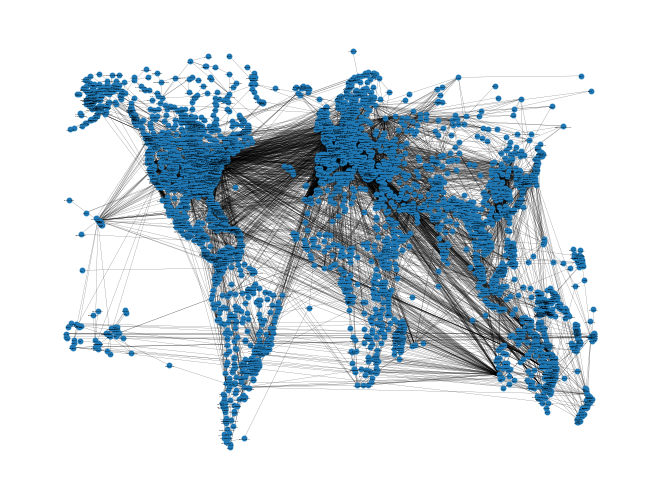

In [3]:
node_positions = {node: (data['lon'], data['lat']) for node, data in G.nodes(data=True)}
labels = {node: (data['city_name']) for node, data in G.nodes(data=True)}
nx.draw_networkx_edges
nx.draw(G, pos=node_positions, with_labels=True, labels=labels, font_size=1, node_size=10, width = 0.1)
plt.plot()

In [4]:
encoder = LabelEncoder()
integer_labels = encoder.fit_transform(data.country)
target_tensor = torch.tensor(integer_labels, dtype=torch.long)
data.y = target_tensor
data.num_classes = len(set(data.country))

In [ ]:
num_nodes = data.num_nodes
train_ratio = 0.80 # 80% of nodes for training
# Randomly creating a mask
mask = torch.rand(num_nodes) < train_ratio
data.train_mask = mask
data.test_mask = data.train_mask
# remove the attributes for the nodes that are not in the training set
temp = torch.zeros((num_nodes, 2), dtype=torch.float)
temp[data.train_mask] = data.x[data.train_mask]
data.x = temp

In [ ]:
print(data.x)

tensor([[-145.5097,  -17.3539],
        [-140.9500,  -18.0667],
        [-149.6000,  -17.5500],
        ...,
        [-113.2039,   54.7431],
        [ 146.6000,   -6.1333],
        [ 147.2500,   -6.0000]])


In [ ]:
model = GCN(dim_in=data.num_features, dim_h=100, dim_out=data.num_classes)
model.fit(data, 100)

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


In [ ]:
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.5630


In [4]:
G.graph = {} 
encoder = LabelEncoder()
encoder.fit([G.nodes[node]["country"] for node in G.nodes])

for node in G.nodes :
    G.nodes[node]["country_code"] = encoder.transform([G.nodes[node]["country"]])[0]


data = from_networkx(G, group_node_attrs=["lon","lat","country_code"])

Data(edge_index=[2, 27094], population=[3363], country=[3363], city_name=[3363], x=[3363, 3])
3


## Test du Dropout

In [2]:
# Reconstruction du graphe
G = nx.read_graphml("data/airportsAndCoordAndPop.graphml")
G.graph = {}
encoder = LabelEncoder()
encoder.fit([G.nodes[node]["country"] for node in G.nodes])

for node in G.nodes :
    G.nodes[node]["country_code"] = encoder.transform([G.nodes[node]["country"]])[0]
    G.nodes[node]["degree"] = G.degree()[node]

data = from_networkx(G, group_node_attrs=["lat", "lon", "degree","country_code"])

In [ ]:

AUCs, APs = test_dropout(
    "test_dropout/test.csv", 
    data, 
    list(
        product(
            [
                (True, .0), 
                (False, .0),
                (True, .5),
            ],
            [True, False],
            [32]
        )
    ),
    2000, 
    test_interval= 1, 
    n=100, 
    average_on= 10
)

In [ ]:
AUCs, APs = get_AUCs_APs()

In [15]:
# Reconstruction du graphe
G_no_degree = nx.read_graphml("data/airportsAndCoordAndPop.graphml")
G_no_degree.graph = {}
encoder = LabelEncoder()
encoder.fit([G_no_degree.nodes[node]["country"] for node in G_no_degree.nodes])

for node in G.nodes :
    G_no_degree.nodes[node]["country_code"] = encoder.transform([G_no_degree.nodes[node]["country"]])[0]

data_no_degree = from_networkx(G_no_degree, group_node_attrs=["lat", "lon", "country_code"])

In [20]:

AUCs_no_degree, APs_no_degree = test_dropout(
    "test_dropout/test_no_degree.csv", 
    data_no_degree, 
    list(
        product(
            [
                (True, .0), 
                (False, .0),
                (True, .5),
            ],
            [True, False],
            [32]
        )
    ),
    2000, 
    test_interval= 1, 
    n=60, 
    average_on= 1
)

0it [00:00, ?it/s]

reimported test_dropoutreimported test_dropout

reimported test_dropout
reimported test_dropout


start plotting


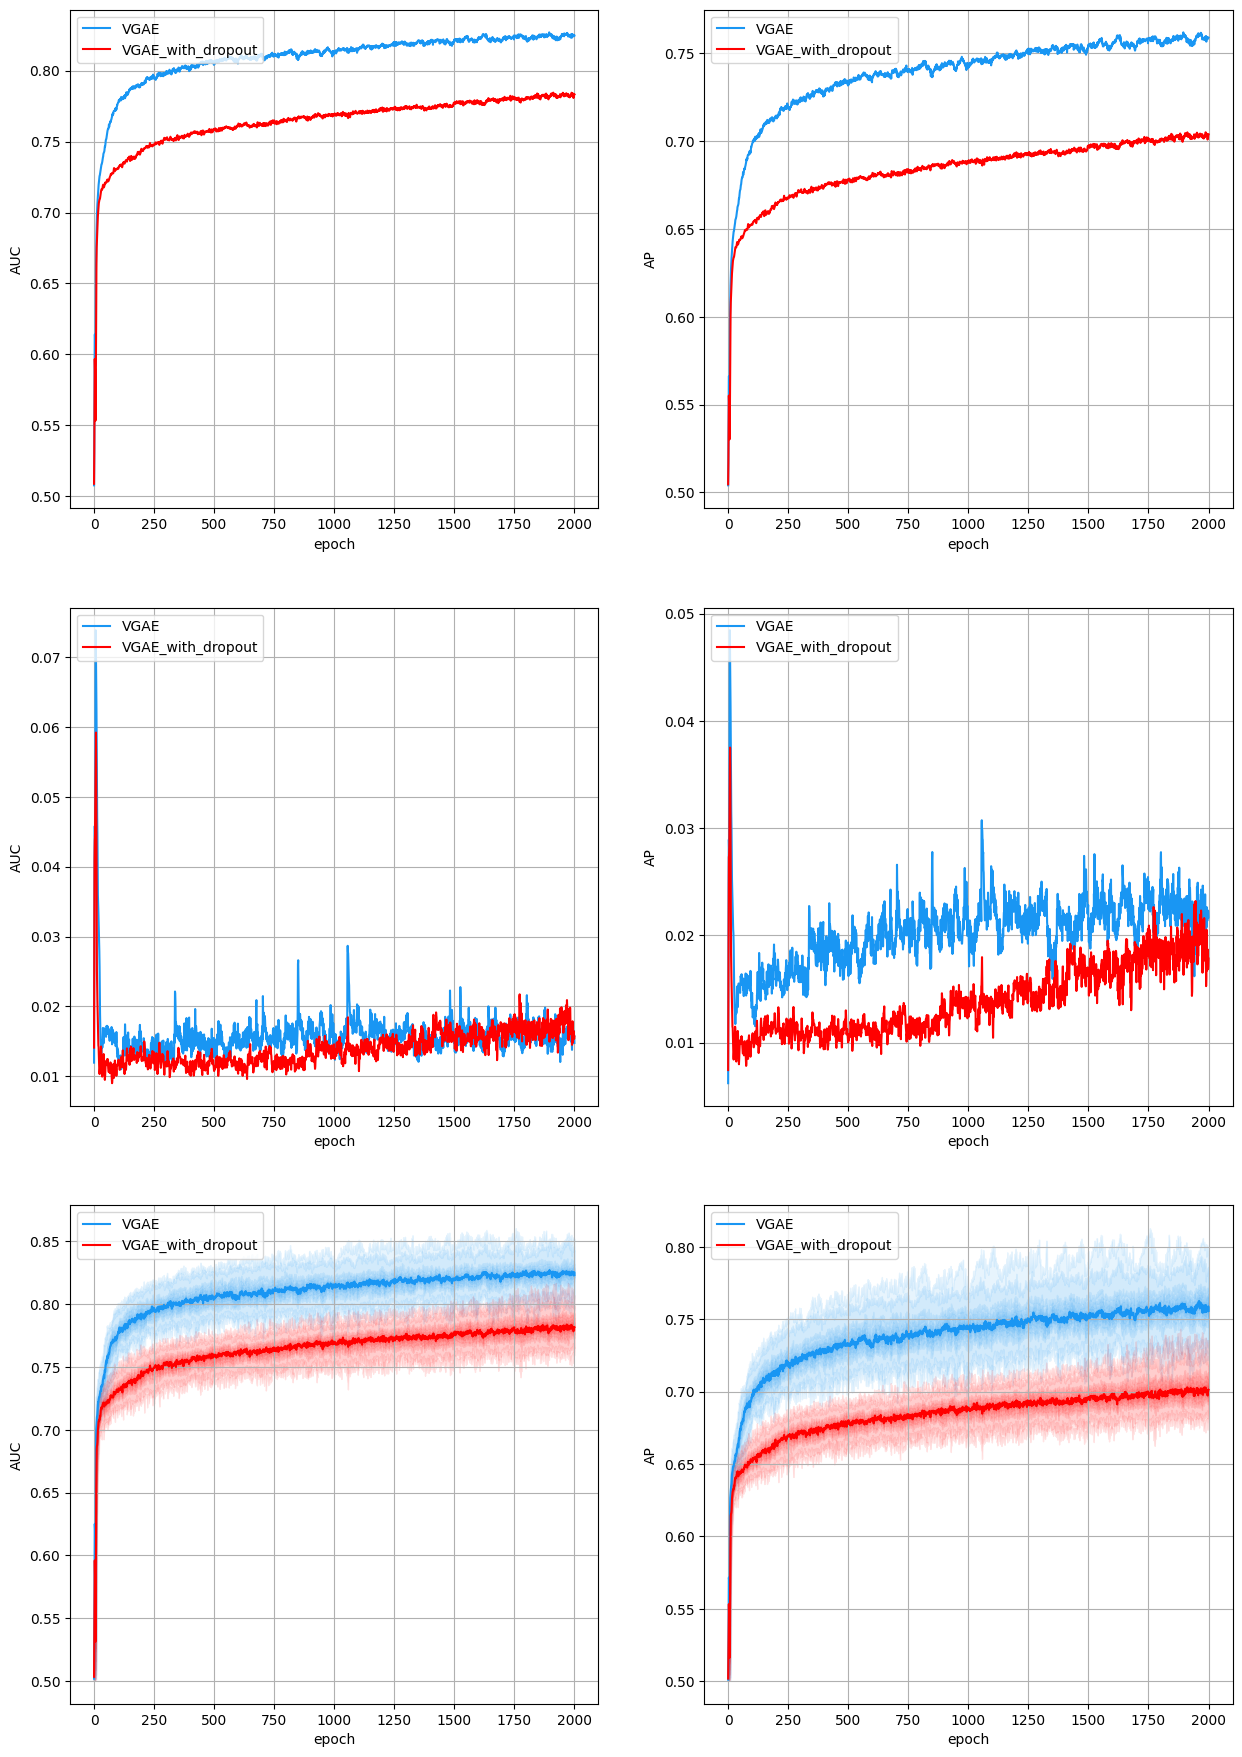

In [19]:
from test_dropout import draw_AUCs_APs
draw_AUCs_APs(AUCs,APs,1,1,["VGAE","VGAE_with_dropout"])

In [48]:
mean_data = pd.read_csv("test_dropout/test1.csv", sep=";")
mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] = mean_data[["Dropout", "AUC", "AP", "elapsed_time"]].applymap(lambda x: 0)

for i in range(10):
    df = pd.read_csv("test_dropout/test"+ str(i+1) + ".csv", sep=";")
    mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] = mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] + df[["Dropout", "AUC", "AP", "elapsed_time"]] / 10.0

mean_data[["Dropout"]] = mean_data[["Dropout"]].round(1)
mean_data.to_csv("test_dropout/mean.csv", sep=";", index=False)
mean_data

/tmp/ipykernel_87409/1360025467.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mean_data[["Dropout", "AUC", "AP", "elapsed_time"]] = mean_data[["Dropout", "AUC", "AP", "elapsed_time"]].applymap(lambda x: 0)


Dropout       AUC        AP  epochs  elapsed_time
0      0.0  0.944674  0.929142    2000     42.126361
1      0.1  0.918398  0.906737    2000     41.715540
2      0.2  0.931087  0.932548    2000     41.847366
3      0.3  0.914220  0.918895    2000     41.685487
4      0.4  0.910201  0.913932    2000     41.578512
5      0.5  0.900713  0.904036    2000     41.639460
6      0.6  0.881984  0.882945    2000     41.636460
7      0.7  0.880589  0.882256    2000     41.681939

## Performance de notre Decodeur

In [6]:
def fit_vgae(model, optimizer, data, epochs, verbose=True):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    if verbose and epochs % 100 == 0:
        print("epoch:", epochs, " : ", loss.item(), end="\r")
    epochs -= 1
    if epochs > 0:
        fit_vgae(model, optimizer, data, epochs, verbose)
        
def fit_gae(model, optimizer, data, epochs, verbose=True):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss.backward()
    optimizer.step()
    if verbose and epochs % 100 == 0:
        print("epoch:", epochs, " : ", loss.item(), end="\r")
    epochs -= 1
    if epochs > 0:
        fit_gae(model, optimizer, data, epochs, verbose)

def test(file_path, data, epochs, n=10, type="vgae", encoder_out=32, decoder=True):
    f = open(file_path, "w")
    f.write("epoch;AUC;AP\n")
    for i in range(n):
        transform = RandomLinkSplit(is_undirected=True, split_labels=True, num_val=0)
        train_data, _, test_data = transform(data)
        dt = data.__copy__()
        dt.train_pos_edge_index = train_data.pos_edge_label_index
        dt.test_pos_edge_index = test_data.pos_edge_label_index
        dt.test_neg_edge_index = test_data.neg_edge_label_index
        
        # init model
        if type=="vgae":
            model = VGAE(Encoder(dt.num_features, encoder_out, dropout=0), Decoder(encoder_out) if decoder else None)
        elif type=="gae":
            model = GAE(GCN(dt.num_features, encoder_out), Decoder(encoder_out) if decoder else None)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        for j in range(epochs):
            if type=="vgae":
                fit_vgae(model, optimizer, dt, 1, verbose=False)
            elif type=="gae":
                fit_gae(model, optimizer, dt, 1, verbose=False)
            with torch.no_grad():
                model.eval()
                z = model.encode(dt.x, dt.train_pos_edge_index)
                result = model.test(z, dt.test_pos_edge_index, dt.test_neg_edge_index)
                model.train()
            f.write(str(j) + ";" + str(result[0]) + ";" + str(result[1]) + "\n")
            if j % 100 == 0 or j==epochs-1:
                print("n:", i, "epoch:", j, " : ", result, end=("\r" if j!=epochs-1 else "\n"))
    f.close()

reimported test_dropout


In [7]:
# Reconstruction du graphe
G = nx.read_graphml("data/airportsAndCoordAndPop.graphml")
G.graph = {}
encoder = LabelEncoder()
encoder.fit([G.nodes[node]["country"] for node in G.nodes])

for node in G.nodes :
    G.nodes[node]["country_code"] = encoder.transform([G.nodes[node]["country"]])[0]
    G.nodes[node]["degree"] = G.degree()[node]

data = from_networkx(G, group_node_attrs=["lat", "lon", "country_code"])

In [5]:
test("test_performance/test_vgae_without_decoder.csv", data, 1000, n=10, type="vgae", encoder_out=32, decoder=False)
test("test_performance/test_vgae_with_decoder.csv", data, 1000, n=10, type="vgae", encoder_out=32, decoder=True)
test("test_performance/test_gae_without_decoder.csv", data, 1000, n=10, type="gae", encoder_out=32, decoder=False)
test("test_performance/test_gae_with_decoder.csv", data, 1000, n=10, type="gae", encoder_out=32, decoder=True)

amdgpu.ids: No such file or directory
amdgpu.ids: No such file or directory


n: 0 epoch: 999  :  (0.8108662169673269, 0.729649242199198))
n: 1 epoch: 999  :  (0.8360485351522978, 0.758438411522064))
n: 2 epoch: 999  :  (0.8218798446205796, 0.7412702635392041)
n: 3 epoch: 999  :  (0.8112961988673442, 0.7302424470636538)
n: 4 epoch: 999  :  (0.86081456599626, 0.7939596770973549)9)
n: 5 epoch: 999  :  (0.8338982168594058, 0.7587990943401287)
n: 6 epoch: 999  :  (0.8368098436217626, 0.7645474987559708)
n: 7 epoch: 999  :  (0.8282893070294239, 0.7524081609713085)
n: 8 epoch: 999  :  (0.8296613519513929, 0.7515231764487927)
n: 9 epoch: 999  :  (0.8387894227859203, 0.7643196458153323)
n: 0 epoch: 999  :  (0.9720244005700752, 0.9696851851530297)
n: 1 epoch: 999  :  (0.9784089266177396, 0.9741370148643694)
n: 2 epoch: 999  :  (0.9699692628688996, 0.9657379381387908)
n: 3 epoch: 999  :  (0.9480443420282201, 0.935104027962526))
n: 4 epoch: 999  :  (0.9750789004182087, 0.9717113414261287)
n: 5 epoch: 999  :  (0.9707591868348006, 0.968697834682619))
n: 6 epoch: 999  :  (0.9

AUC
VGAE with decoder :  0.9653505786666567
VGAE without decoder :  0.7780345337261559
GAE with decoder :  0.9720150937205201
GAE without decoder :  0.7380466190041507
AP
VGAE with decoder :  0.9634312980049982
VGAE without decoder :  0.6990749427770714
GAE with decoder :  0.9704511208609337
GAE without decoder :  0.6574720954441554


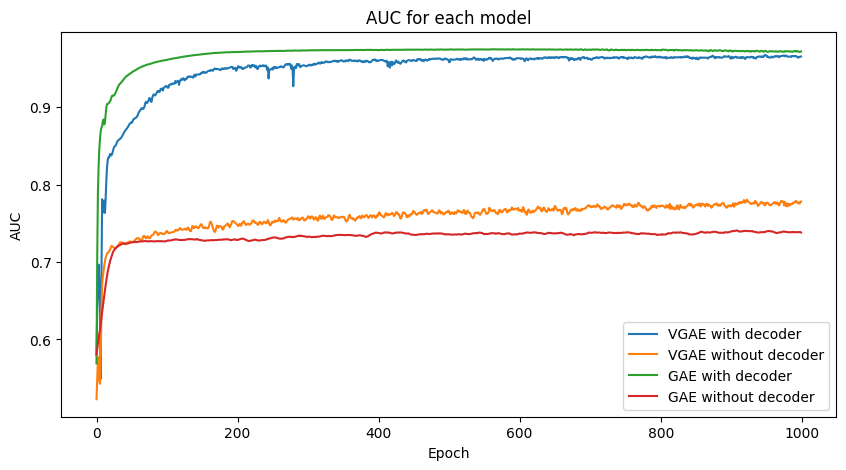

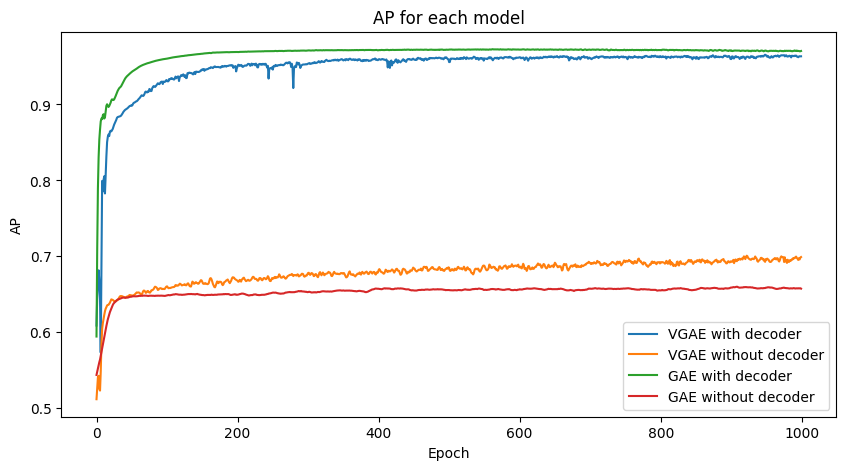

In [15]:
columns = ['epoch', 'AUC', 'AP']
subrepo = "avec_degre_0dropout/"
wd = pd.read_csv("test_performance/"+subrepo+"test_vgae_with_decoder.csv", sep=';', names=columns, skiprows=1)
wod = pd.read_csv("test_performance/"+subrepo+"test_vgae_without_decoder.csv", sep=';', names=columns, skiprows=1)
dgae_wd = pd.read_csv("test_performance/"+subrepo+"test_gae_with_decoder.csv", sep=';', names=columns, skiprows=1)
dgae_wod = pd.read_csv("test_performance/"+subrepo+"test_gae_without_decoder.csv", sep=';', names=columns, skiprows=1)

# Faire la moyenne des AUC et AP pour n=10 pour chaque epoch=1000
model1 = wd.groupby('epoch').agg({'AUC': 'mean', 'AP': 'mean'})
model2 = wod.groupby('epoch').agg({'AUC': 'mean', 'AP': 'mean'})
model3 = dgae_wd.groupby('epoch').agg({'AUC': 'mean', 'AP': 'mean'})
model4 = dgae_wod.groupby('epoch').agg({'AUC': 'mean', 'AP': 'mean'})

# Plot AUC
plt.figure(figsize=(10, 5))
plt.plot(model1["AUC"], label="VGAE with decoder")
plt.plot(model2["AUC"], label="VGAE without decoder")
plt.plot(model3["AUC"], label="GAE with decoder")
plt.plot(model4["AUC"], label="GAE without decoder")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("AUC for each model")
plt.savefig("test_performance/AUC.png", dpi=1000)

# Plot AP
plt.figure(figsize=(10, 5))
plt.plot(model1["AP"], label="VGAE with decoder")
plt.plot(model2["AP"], label="VGAE without decoder")
plt.plot(model3["AP"], label="GAE with decoder")
plt.plot(model4["AP"], label="GAE without decoder")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("AP")
plt.title("AP for each model")
plt.savefig("test_performance/AP.png", dpi=1000)

print("AUC")
print("VGAE with decoder : ", model1["AUC"][len(model1)-1])
print("VGAE without decoder : ", model2["AUC"][len(model2)-1])
print("GAE with decoder : ", model3["AUC"][len(model3)-1])
print("GAE without decoder : ", model4["AUC"][len(model4)-1])
print("AP")
print("VGAE with decoder : ", model1["AP"][len(model1)-1])
print("VGAE without decoder : ", model2["AP"][len(model2)-1])
print("GAE with decoder : ", model3["AP"][len(model3)-1])
print("GAE without decoder : ", model4["AP"][len(model4)-1])

## Reconstruction de graphe

In [8]:
true_edges = G.edges
nodes_list = np.array(list(G.nodes()))

dt = data.__copy__()
# train_test_split_edges(dt, val_ratio=0.0)
transform = RandomLinkSplit(is_undirected=True, split_labels=True, num_val=0)
train_data, _, test_data = transform(data)
dt.train_pos_edge_index = train_data.pos_edge_label_index
dt.test_pos_edge_index = test_data.pos_edge_label_index
dt.test_neg_edge_index = test_data.neg_edge_label_index

In [34]:
encoder = Encoder(in_channels=dt.num_features, out_channels=15, dropout=0.3)
decoder = Decoder(15)

vgae = VGAE(encoder, decoder)
vgaeWithoutDecoder = VGAE(Encoder(in_channels=dt.num_features, out_channels=15, dropout=0))
gae = GAE(GCN(data.num_features, 15))
gaeWithDecoder = GAE(GCN(data.num_features, 15), Decoder(15))

epochs = 1500

fit_vgae(vgae, torch.optim.Adam(vgae.parameters(), lr=0.01, weight_decay=5e-4), dt, epochs, verbose=True)
fit_vgae(vgaeWithoutDecoder, torch.optim.Adam(vgaeWithoutDecoder.parameters(), lr=0.01, weight_decay=5e-4), dt, epochs, verbose=True)
fit_gae(gae, torch.optim.Adam(gae.parameters(), lr=0.01, weight_decay=5e-4), dt, epochs, verbose=True)
fit_gae(gaeWithDecoder, torch.optim.Adam(gaeWithDecoder.parameters(), lr=0.01, weight_decay=5e-4), dt, epochs, verbose=True)

In [11]:
def predict_graph(data, model, G, edges_index, true_edges, sigmoid, file_path):
    print("> Predicting edges...")
    with torch.no_grad():
        model.eval()
        z = model.decoder(model.encode(data.x, data.train_pos_edge_index), edges_index, sigmoid=sigmoid)
    edges_transpose = torch.transpose(edges_index, 0, 1)

    print(len(z), " possible edges")
    print('Prediction min(%.5f) and max(%.5f)' % (torch.min(z).item(), torch.max(z).item()))
    print("Prediction mean(%.5f) and std(%.5f)" % (torch.mean(z).item(), torch.std(z).item()))

    #---
    print("> Selecting edges...")
    threshold = torch.quantile(z, 0.5)#max(1 - len(true_edges) / edges_transpose.shape[0], 0), interpolation='nearest')
    print("Threshold : ", threshold.item())
    G.clear_edges()
    rejected_edges = 0
    for i in range(edges_transpose.shape[0]):
        source, target = edges_transpose[i]
        edge = (nodes_list[source.item()], nodes_list[target.item()])
        if z[i] >= threshold :
            G.add_edge(*edge, color = 'black' if edge in true_edges else 'r')
        elif edge in true_edges :
            G.add_edge(*edge, color = 'g')
        else :
            rejected_edges += 1
        
        if i % 100 == 0:
            print(i, ' / ', edges_transpose.shape[0], end="\r")

    count = {'black':0, 'r':0, 'g':0}
    color = nx.get_edge_attributes(G,'color')
    for edge in G.edges:
        count[color[edge]] += 1
    print(count['black'], " correctly predicted")
    print(count['r'], " wrongly predicted")
    print(count['g'], " missed")
    print(rejected_edges, " rejected")

    #---
    print("> Printing...")
    node_positions = {}
    labels = {}
    for node, data in G.nodes(data=True):
        try:
            node_positions[node] = (data['lon'], data['lat'])
            labels[node] = (data['city_name'])
        except:
            node_positions[node] = (0,0)
            labels[node] = ('unknown')

    # Tracez le graphe
    nx.draw_networkx_edges
    nx.draw(G, pos=node_positions, with_labels=True, labels=labels, font_size=1, node_size=10, width = 0.05, edge_color=nx.get_edge_attributes(G,'color').values())

    plt.savefig(file_path, dpi=1000)

    return z

In [13]:
edge_index_combinations = torch.cat((train_data.pos_edge_label_index, train_data.neg_edge_label_index, test_data.pos_edge_label_index, test_data.neg_edge_label_index), dim=1)
# Shuffle
edge_index_combinations = edge_index_combinations[:, torch.randperm(edge_index_combinations.shape[1])]

> Predicting edges...
27094  possible edges
Prediction min(0.00000) and max(1.00000)
Prediction mean(0.51289) and std(0.43108)
> Selecting edges...
Threshold :  0.5917894840240479
12535  correctly predicted
1011  wrongly predicted
1012  missed
12535  rejected
> Printing...


tensor([0.9960, 0.8846, 0.0316,  ..., 0.9984, 0.8923, 0.9746])

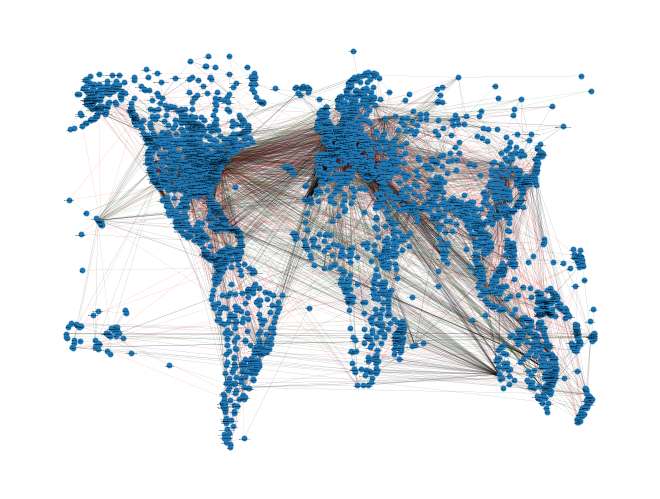

In [22]:
predict_graph(dt, vgae, G.copy(), edge_index_combinations, true_edges, True, "withDecoder.png")

> Predicting edges...
27094  possible edges
Prediction min(0.00000) and max(1.00000)
Prediction mean(0.75625) and std(0.41074)
> Selecting edges...
Threshold :  1.0
11665  correctly predicted
3995  wrongly predicted
1882  missed
9545  rejected
> Printing...


tensor([1.0000, 0.9999, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

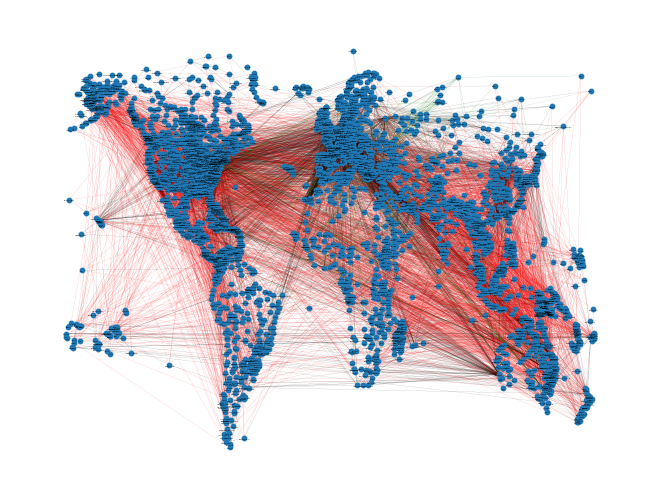

In [23]:
predict_graph(dt, vgaeWithoutDecoder, G.copy(), edge_index_combinations, true_edges, True, "withoutDecoder.png")

> Predicting edges...
27094  possible edges
Prediction min(0.00000) and max(1.00000)
Prediction mean(0.73815) and std(0.43963)
> Selecting edges...
Threshold :  1.0
13239  correctly predicted
6745  wrongly predicted
308  missed
6797  rejected
> Printing...


tensor([1., 1., 1.,  ..., 1., 1., 1.])

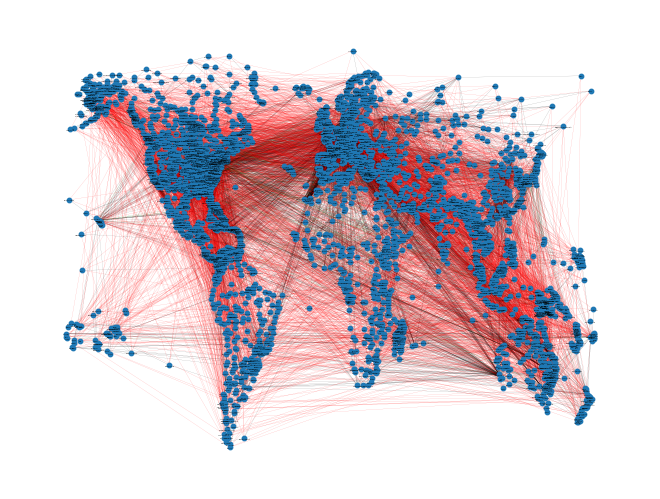

In [24]:
predict_graph(dt, gae, G.copy(), edge_index_combinations, true_edges, True, "GCN.png")

> Predicting edges...3755559921268
27094  possible edges
Prediction min(0.00000) and max(0.99989)
Prediction mean(0.48896) and std(0.39846)
> Selecting edges...
Threshold :  0.5601402521133423
11874  correctly predicted
1673  wrongly predicted
1673  missed
11874  rejected
> Printing...


tensor([0.0468, 0.7989, 0.8707,  ..., 0.0072, 0.1102, 0.6309])

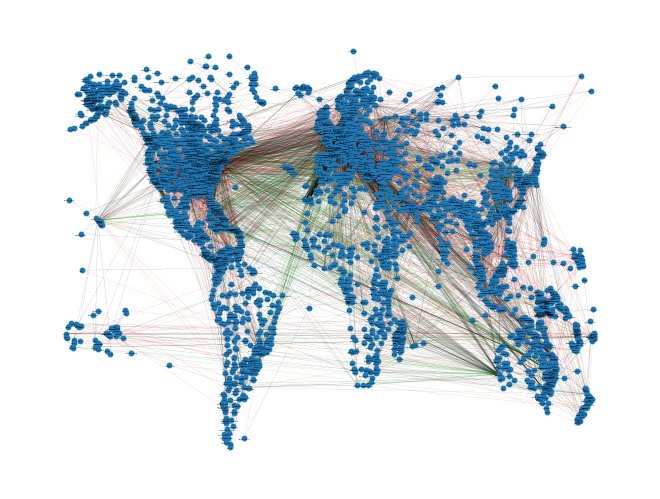

In [14]:
predict_graph(dt, gaeWithDecoder, G.copy(), edge_index_combinations, true_edges, True, "GCNWithDecoder.png")